<a href="https://colab.research.google.com/github/ajdduck/DataScience_Python/blob/master/kakao_gift_take.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from mlxtend.preprocessing import TransactionEncoder 
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# 나눔고딕 설치

!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

font = fm.FontProperties(fname=fontpath, size=9)

fm._rebuild()

# 그래프에 retina display 적용

%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정

plt.rc('font', family='NanumBarunGothic') 

In [3]:
df_take = pd.read_csv("/content/drive/My Drive/df_take.csv")
df_take.head()

,사용 횟수,만족 이유,선물 상황,상품의 가격대,나의 필요성,상품의 종류,상품의 품질,받은 선물,성별,직업,나이
0,4회 이상,a,"A, B",2,4,4,4,mobile,여,대학생,20대
1,1회,a,"A, C",3,4,4,4,mobile,여,대학생,20대
2,1회,a,"A, C",2,3,4,3,mobile,여,대학생,20대
3,1회 미만,b,"A, B",2,3,3,2,mobile,여,대학생,20대
4,1회,b,"A, E",2,2,3,3,mobile,여,대학생,20대


In [4]:
s = df_take['만족 이유'].value_counts()
df_satis_reason = s.to_frame()
df_satis_reason.sort_index(inplace = True)

df_satis_reason

,만족 이유
a,11
b,25
c,15


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47564 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51313 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47564 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backe

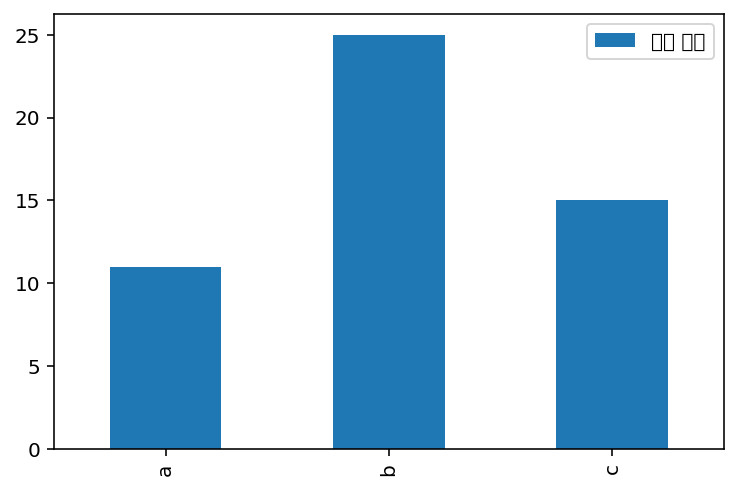

In [5]:
df_satis_reason.plot(kind = 'bar')

In [6]:
df_gift_kind = df_take['받은 선물'].value_counts().to_frame()
df_gift_kind

,받은 선물
mobile,45
delivery,6


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0355bfbe48>],
      dtype=object)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48155 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47932 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48155 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_te

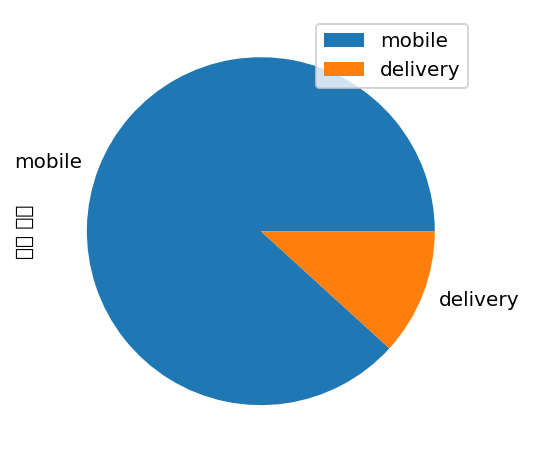

In [7]:
df_gift_kind.plot(kind='pie', subplots = True)

In [8]:
df_take_mod = df_take.copy()
df_take_mod = df_take_mod[['사용 횟수', '만족 이유', '선물 상황', '상품의 가격대']]
df_take_mod.head()

,사용 횟수,만족 이유,선물 상황,상품의 가격대
0,4회 이상,a,"A, B",2
1,1회,a,"A, C",3
2,1회,a,"A, C",2
3,1회 미만,b,"A, B",2
4,1회,b,"A, E",2


In [9]:
df_take_mod.columns = ['var1', 'var2', 'var3', 'var4']

df_take_mod = (df_take_mod.set_index(df_take_mod.columns.drop('var3', 2).tolist())
                          .var3.str.split(', ', expand=True)
                          .stack()
                          .reset_index()
                          .rename(columns={0:'var3'})
                          .loc[:, df_take_mod.columns]
                        )
df_take_mod.head()

,var1,var2,var3,var4
0,4회 이상,a,A,2
1,4회 이상,a,B,2
2,1회,a,A,3
3,1회,a,C,3
4,1회,a,A,2


In [10]:
df_take_mod.columns = ['사용 횟수', '만족 이유', '선물 상황', '상품의 가격대']
df_take_mod.head()

,사용 횟수,만족 이유,선물 상황,상품의 가격대
0,4회 이상,a,A,2
1,4회 이상,a,B,2
2,1회,a,A,3
3,1회,a,C,3
4,1회,a,A,2


In [11]:
df_take_reason = df_take_mod['선물 상황'].value_counts().to_frame().sort_index()
df_take_reason

,선물 상황
A,40
B,19
C,25
D,2
E,11
F,3
G,2


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47932 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54889 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47932 missing from current font.
  font.set_te

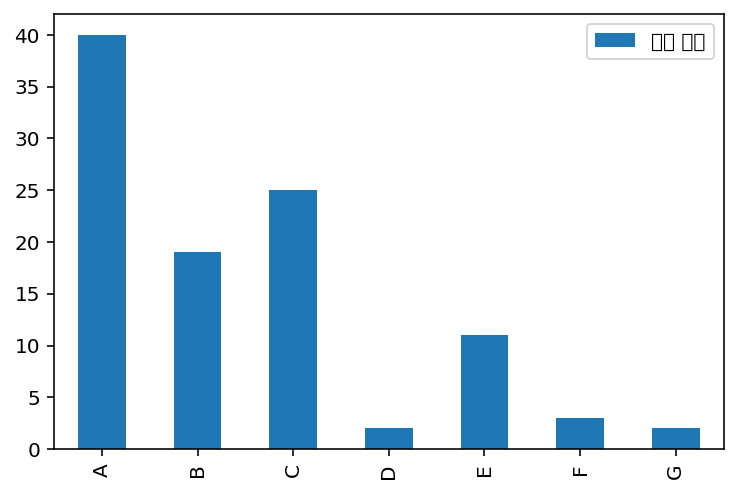

In [12]:
df_take_reason.plot(kind = 'bar')

In [0]:
df_take_mod = df_take.copy()
df_take_mod = df_take_mod[['만족 이유', '선물 상황', '받은 선물']]

df_take_mod.columns = ['var1', 'var2', 'var3']

df_take_mod = (df_take_mod.set_index(df_take_mod.columns.drop('var2', 1).tolist())
                          .var2.str.split(', ', expand=True)
                          .stack()
                          .reset_index()
                          .rename(columns={0:'var2'})
                          .loc[:, df_take_mod.columns]
                        )

df_take_mod.columns = ['만족 이유', '선물 상황', '받은 선물']

In [0]:
df_take_mod = df_take_mod.astype({'받은 선물':str})
rows_number = df_take_mod.shape[0]

dataset = []

for i in range(rows_number):
  row_list = df_take_mod.loc[i, :].tolist()
  dataset.append(row_list)

In [0]:
te = TransactionEncoder() 
te_result = te.fit(dataset).transform(dataset)

df = pd.DataFrame(te_result, columns=te.columns_)

In [16]:
itemset = apriori(df, use_colnames=True) 
itemset

,support,itemsets
0,0.882353,(mobile)


In [17]:
itemset = apriori(df, min_support=0.3, use_colnames=True) 
itemset

,support,itemsets
0,0.392157,(A)
1,0.490196,(b)
2,0.882353,(mobile)
3,0.343137,"(mobile, A)"
4,0.470588,"(b, mobile)"


In [18]:
association_rules(itemset, metric="confidence", min_threshold=0.1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(mobile),(A),0.882353,0.392157,0.343137,0.388889,0.991667,-0.002884,0.994652
1,(A),(mobile),0.392157,0.882353,0.343137,0.875000,0.991667,-0.002884,0.941176
2,(b),(mobile),0.490196,0.882353,0.470588,0.960000,1.088000,0.038062,2.941176
3,(mobile),(b),0.882353,0.490196,0.470588,0.533333,1.088000,0.038062,1.092437
